In [639]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    load_vehicle_profiles_from_csv,  # falls du weiter oben die Flotte anschauen willst
)

In [640]:

# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "logistics_center"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions = simulate_load_profile(scenario)

In [641]:
# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

# ---------------------------------------------------------------------------
# Überblick: Anzahl Sessions und Beispiel-Sessions
# ---------------------------------------------------------------------------
print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("\nBeispiel-Sessions (erste 10):")

for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "      #NEU
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"           # NEU
    )

# ---------------------------------------------------------------------------
# Auswertung: welche Fahrzeuge wurden wie oft geladen?
# ---------------------------------------------------------------------------
vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

print("\nVerwendete Fahrzeuge im Simulationshorizont:")
for model, n in counts.items():
    print(f"- {model}: {n} Sessions")

Verwendetes Szenario: logistics_center
Erster Timestamp: 2025-05-22 00:00:00
Letzter Timestamp: 2025-05-23 23:50:00
Simulationshorizont: 2 Tage

Anzahl Ladesessions im Simulationshorizont: 27

Beispiel-Sessions (erste 10):
Fahrzeug: 2 LR SM, Ankunft: 2025-05-22 06:08:34.868240, Abfahrt: 2025-05-22 08:16:10.232330, Kapazität: 100.0 kWh, geladene Energie: 89.3 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Taycan, Ankunft: 2025-05-22 07:20:07.523271, Abfahrt: 2025-05-22 17:13:38.649647, Kapazität: 93.0 kWh, geladene Energie: 91.2 kWh, Restbedarf: 0.0 kWh
Fahrzeug: iX M60 xDrive, Ankunft: 2025-05-22 08:12:41.224529, Abfahrt: 2025-05-22 18:12:41.224529, Kapazität: 102.0 kWh, geladene Energie: 80.2 kWh, Restbedarf: 0.0 kWh
Fahrzeug: 2 LR SM, Ankunft: 2025-05-22 11:29:05.773589, Abfahrt: 2025-05-22 14:38:11.589177, Kapazität: 100.0 kWh, geladene Energie: 91.5 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Niro EV, Ankunft: 2025-05-22 11:49:21.179862, Abfahrt: 2025-05-22 19:48:47.260110, Kapazität: 64.0 kWh, geladen

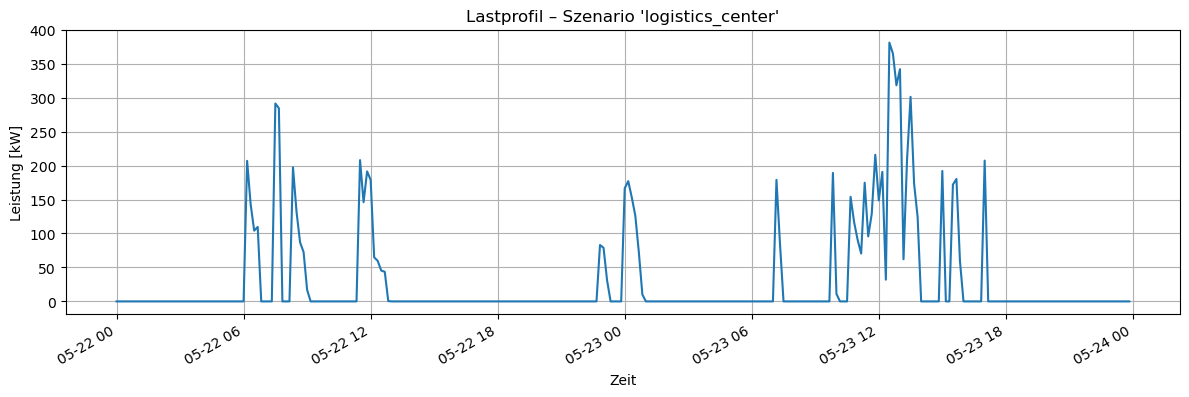

In [642]:
# ---------------------------------------------------------------------------
# 3) Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()
